In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import tensorflow as tf
from src import vrae, train, utils
import numpy as np

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
for gpu in physical_devices:
    tf.config.experimental.set_memory_growth(gpu, True)

batch_size = 512
time_size = 1280
over_len = 128

folder_path = "/works/Data/wellysis/mit-bih-long-term-ecg-database-1.0.0/"
data_col = utils.data_from_mit(folder_path)

tot_data = np.zeros((1,time_size,1),dtype=np.float32)
for key in data_col.keys():
    signal_1 = utils.make_dataformat_from_mit(data_col=data_col, name=key, time_len=time_size, over_len=over_len)
    tot_data = np.concatenate((tot_data, signal_1), axis=0)
tot_data = tot_data[1:]

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
print("Total Data Set shape is : {}".format(tot_data.shape))

Total Data Set shape is : (58975, 1280, 1)


In [3]:
# Return Tensor dataset
def tensorset(arr, shape, batch_size, drop_remainder=False):
    # type casting & reshaping
    data = arr.astype(np.float32)
    data = np.reshape(data, shape)
    # make to tensor
    ds = tf.data.Dataset.from_tensor_slices(data).shuffle(buffer_size=data.shape[0]*3)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    return ds

train_dataset = tensorset(arr=tot_data, shape=(-1, time_size, 1), batch_size=batch_size)

In [4]:
from src import vrae_renew2
mod = vrae_renew2.VRAE(hidden_size=256, latent_length=30, output_depth=1, time_size=time_size, dropout=0.3, recurrent_dropout=0.3)

mod.build(input_shape=(batch_size,time_size,1))
mod.summary()

Model: "vrae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Ecoding_RNN_Cell (SimpleRNNC multiple                  66048     
_________________________________________________________________
RNN_Wrapper (RNN)            multiple                  66048     
_________________________________________________________________
Encoding_MU_Dense (Dense)    multiple                  7710      
_________________________________________________________________
Encoding_STD_Dense (Dense)   multiple                  7710      
_________________________________________________________________
Decoding_first_state_Dense ( multiple                  7936      
_________________________________________________________________
Decoding_RNN_Cell (SimpleRNN multiple                  66048     
_________________________________________________________________
Decoding_mu_Output (Dense)   multiple                  257    

In [5]:
mod.load_weights("/works/GitLab/jomjam/Python/AnomalyDetection/ECG/save/20210810_14_35_42_mit_10s_vrae_256enc_30z_256dec_bernoulliLikelihood_cycleKLD200basic_001kld_dataResample_bat512_lr000001/save")

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

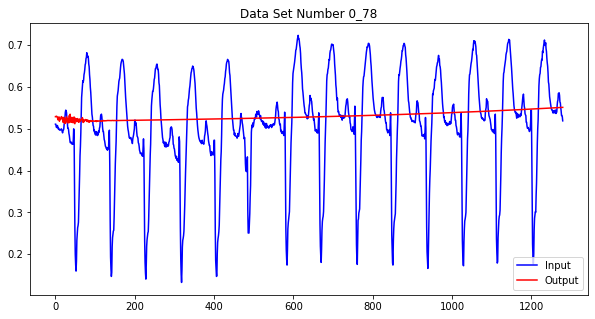

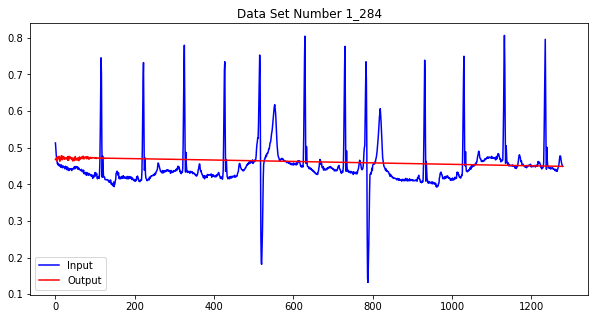

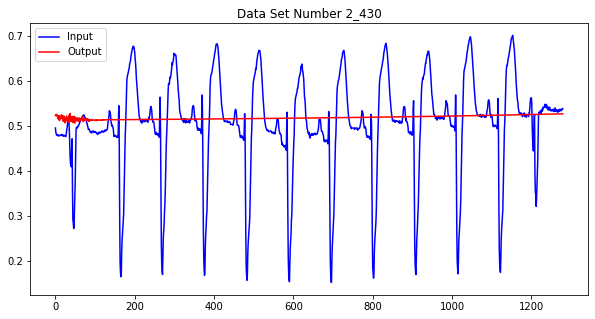

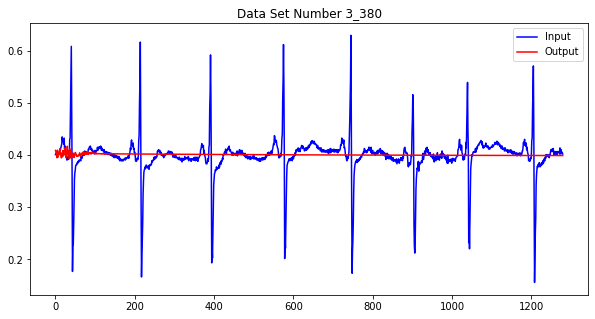

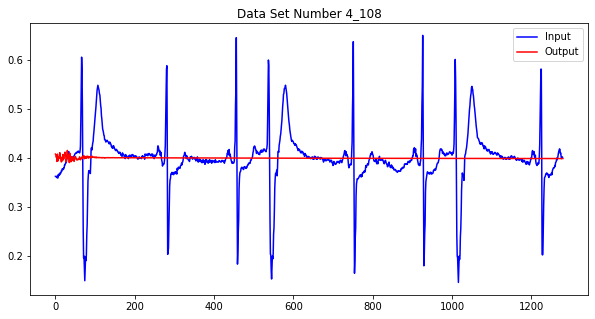

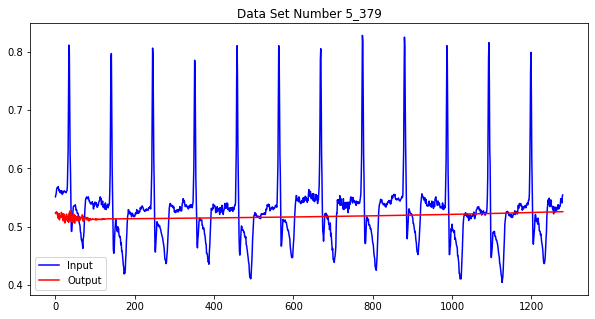

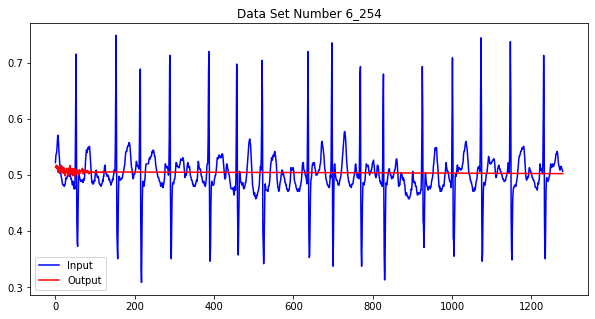

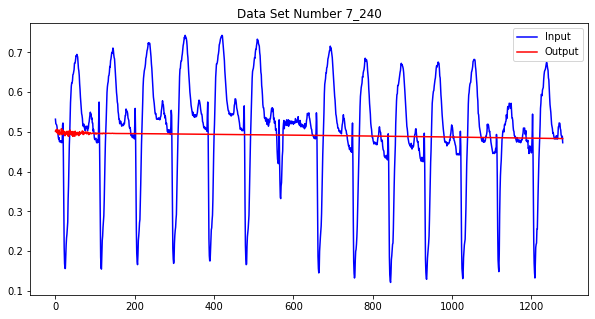

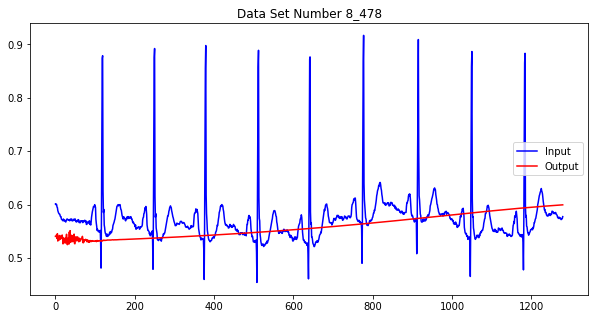

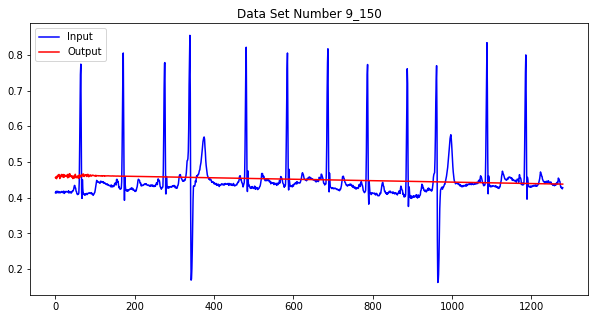

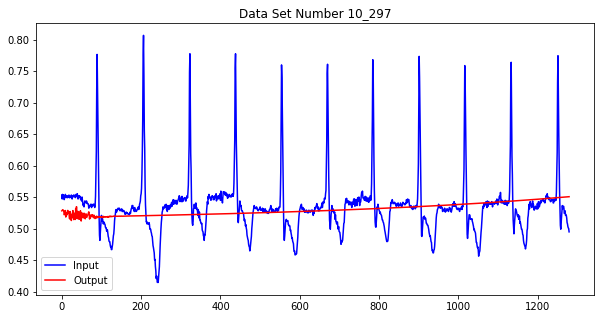

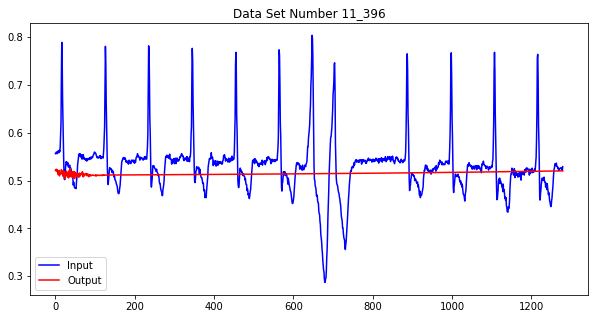

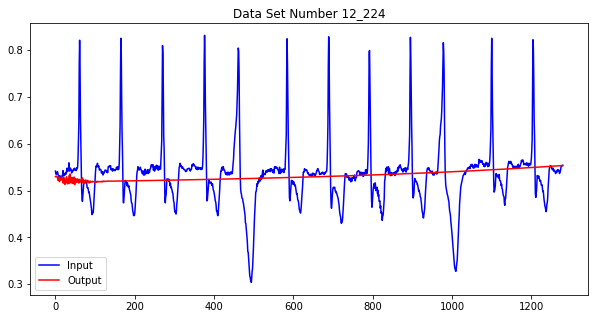

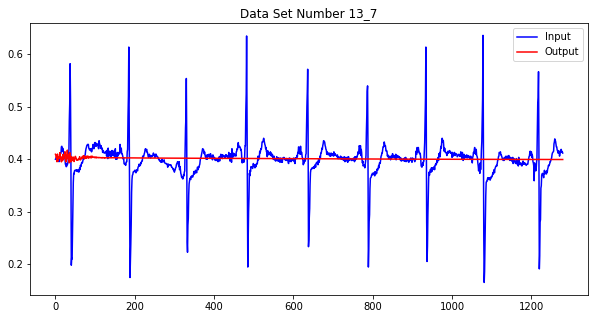

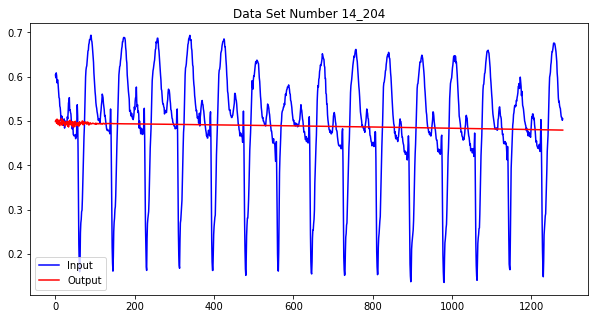

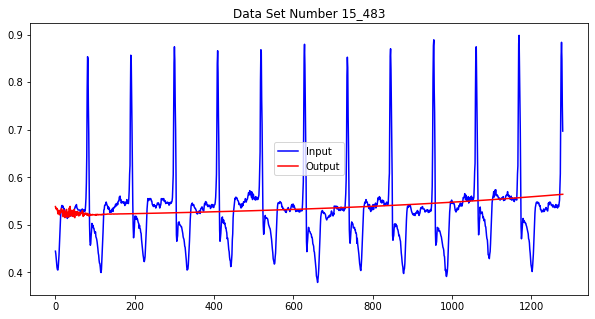

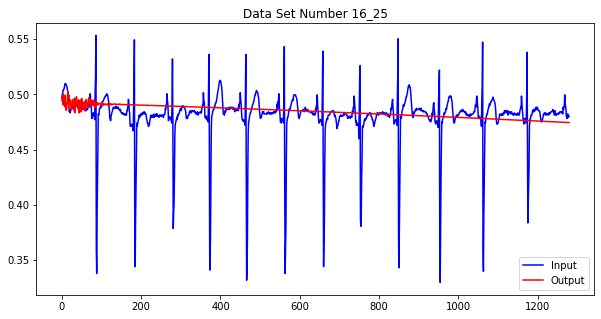

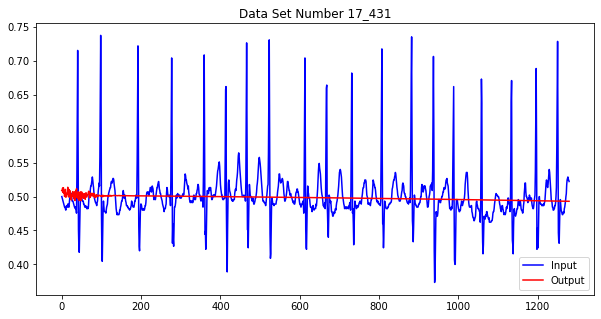

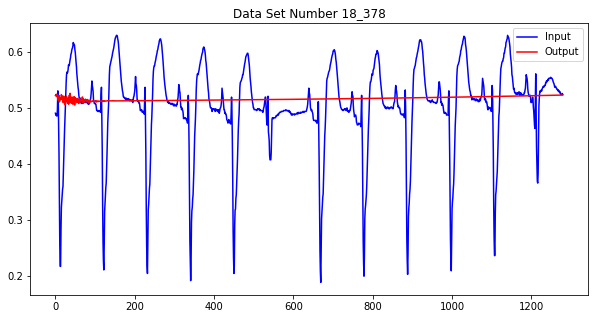

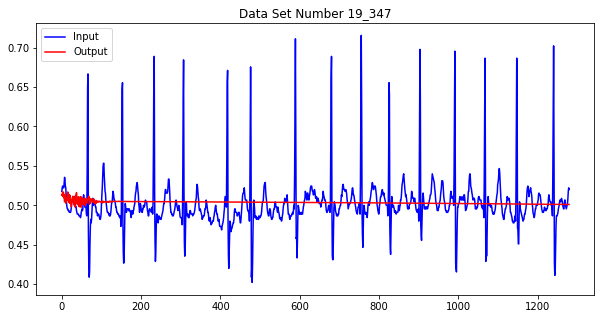

In [7]:
show_num = 20
show_idx = 0

for x in train_dataset:
    output, _, _ = mod(x, False)
    x_arr = x.numpy().reshape(batch_size, time_size)
    y_arr = output.numpy().reshape(batch_size, time_size)
    random_idx = np.random.permutation(x_arr.shape[0])[0]
    
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    ax.plot(np.arange(time_size), x_arr[random_idx], label="Input", color="b")
    ax.plot(np.arange(time_size), y_arr[random_idx], label="Output", color="r")
    ax.legend()
    ax.set_title("Data Set Number {}_{}".format(show_idx, random_idx))
    plt.show()
    
    show_idx += 1
    
    if show_idx == show_num:
        break